### FINAL PROJECT CODE

Our final Project consists of a neural network for classifying songs, Another neural network for analysing user schedule to see if the next song on the playlist should degrease or increase energy. 1 of 2 RNNs are used to analyse song and pick a song with the appropriate song. One RNN is trained to boost song energy and the other to drop energy. The choice of RNN to use is made by the second neural nertwork in the pipeline

In [13]:
# imports 
import pandas as pd
import os
import random
from sklearn import preprocessing as preproc
import numpy as np
import tensorflow as tf
import math

# plotting imports
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib.pyplot as plt

In [2]:
### PREPROCESSING FUNCTIONS
## Some of The Data isn't normalized so gonna make a pre proc function for the playlist data
# so it is ready to be run through through the categorization neural network
def preproc_userdata(df):
    for col in df.columns:
        if col in ["key", "loudness", "tempo"]:
            df[col] = preproc.scale(df[col].values)

    df.dropna(inplace=True)
    data = []
    for row in df.values:
        data.append(np.array(row[2:], dtype=np.float64))
        
    X_data = []
    
    for X in data:
        X_data.append(X)

    
        
    return np.array(X_data)

## HELPER FUNCTIONS

# Function to change song dictionary to a form the RNN is expecting
def song_features(song1, song2):
    song1_key = song1['key_no_norm']
    song1_mode = [song1["mode"]]
    song1_tempo = [song1["tempo"]]
    
    song2_key = song2['key_no_norm']
    song2_mode = [song2["mode"]]
    song2_tempo = [song2["tempo"]]
    
    # Change key into hot key
    song1_keylist = [0] * 12
    song2_keylist = [0] * 12

    song1_keylist[song1_key] = 1
    song2_keylist[song2_key] = 1

    
    # Combine Data
    data1 = song1_mode  + song1_keylist
    data2 = song2_mode  + song2_keylist 
    data =  [ data1, data2 ]
    
    return np.array([data, data])


# Function to get features needed for the time_left neural network
def time_left_feat(activity1, activity2, time_left):
    
    #change activities into hotkeys
    zeros = [0] * 4
    activity1_list = [0] * 4
    activity2_list = [0] * 4
    activity1_list[activity1 -1] = 1
    activity2_list[activity2 -1] = 1
    
    time_left = [time_left]
    
    # Combine Data
    data = activity1_list + activity2_list + time_left
    
    return np.array([data, data])  # putting data because for now the model only accepts a list with more that one row of features


# Converts minutees to hours
def to_minutes(hr):
    return hr*60

#### Step 1: Load Users Playlist Data

In [5]:
DATA_DIR = "DataSets"

user_playlist_file = "TestSongDataSetLess.xlsx"
user_playlist_file = os.path.join(DATA_DIR, user_playlist_file)
user_df = pd.read_excel(user_playlist_file)
# print("---------------------------   USERS RAW DATA   ---------------------------")
key_no_norm = user_df["key"]
# print(user_df.head())

X = preproc_userdata(user_df)

#### Step 2: Use NN to categorize Data

In [6]:
BeastMode = []
Studying = []
BeachSongs = []
Relaxing = []

MODEL_DIR = "Models"

# Load Model
file_name = os.path.join(MODEL_DIR,"simp_neural_net_2l_60n")
Song_categorizer_model = tf.keras.models.load_model(file_name)

# Make Predctions
predictions = Song_categorizer_model.predict(X)

predicted_category = [0] * len(predictions)
# Arg Max The predictions
for i,prediction in enumerate(predictions):
    predicted_category[i] = np.argmax(prediction)
    

for i,prediction in enumerate(predicted_category):
    song_dic = user_df.iloc[i].to_dict()
    song_dic["key_no_norm"] = key_no_norm.iloc[i]
    if prediction == 0:
        BeastMode.append(song_dic)
    elif prediction == 1:
        Studying.append(song_dic)
    elif prediction == 2:
        BeachSongs.append(song_dic)
    elif prediction ==3:
        Relaxing.append(song_dic)


##### Imput Schedule of The USER IN BOTTOM CELL

In [7]:
# for Schedule is a list of tuples. The tuples contain activity and duration
#### Key:
# BeastMode = 1
# Studying = 2
# BeachSongs = 3
# Relaxing = 4


schedule1 = [{"activity":1, "duration":.2},{"activity":2, "duration":.1},{"activity":3, "duration":.2}]  #BeastMode for 2 hrs, Studying for 1 hours, Relaxing for 2 hours
schedule2 = [{"activity":2, "duration":.1},{"activity":1, "duration":.1},{"activity":3, "duration":.2}, {"activity":2, "duration":.1}, {"activity":4, "duration":.1}]
schedule3 = [{"activity":4, "duration":.3},{"activity":1, "duration":.3},{"activity":2, "duration":.2}, {"activity":4, "duration":.3}, {"activity":1, "duration":.5}]
schedule4 = [{"activity":2, "duration":.1},{"activity":1, "duration":.3},{"activity":3, "duration":.2}, {"activity":2, "duration":.1}, {"activity":4, "duration":.1}]


#### Step 4: Load RRN models and Energy Picker Model

In [8]:
MODEL_DIR = "models"
energy_picker_model = "NN_Energy_change_picker"
rnn_boost_model = "RNN_boost1_no_temp"
rnn_drop_model = "RNN_drop1_no_temp"

file_name = os.path.join(MODEL_DIR, energy_picker_model)
energy_changer_NN = tf.keras.models.load_model(file_name)

file_name = os.path.join(MODEL_DIR, rnn_boost_model)
rnn_boost = tf.keras.models.load_model(file_name)

file_name = os.path.join(MODEL_DIR, rnn_drop_model)
rnn_drop = tf.keras.models.load_model(file_name)

#### Step 5: Make Playlist with categorized song data 

In [9]:
# We Are assuming songs last for 3 minutes to know how many songs we need in our playlist

#calculate amount of hours a schedule lasts for


total_time = 0
schedule = schedule4
print("Shedule is", schedule)
for block in schedule:
    duration = block["duration"]
    total_time += duration
total_time = int(to_minutes(total_time))  # conversion into minutes
    
print(f"----- Total Time Scheduled: {total_time} minutes")

song_lib = {1:BeastMode, 2:Studying, 3:BeachSongs, 4:Relaxing}

first_activity = schedule[0]["activity"]
print(f"----- first activity: {first_activity}")

# Shuffle first category
random.shuffle(song_lib[first_activity])
first_song = song_lib[first_activity][0]

def print_song(song, activity=None):
    name = first_song["name"]
    artist = first_song["artist"]
    print(f"----- First song in playlist: Name: {name}, Artist: {artist}, activity: {activity}")

print_song(first_song, first_activity)

# list of tracks (playlist)
playlist = [first_song]

## activity names dictionary
activity_names = {1:"BeastMode", 2:"Studying", 3:"BeachSongs", 4:"Relaxing"}


# Make the entire playlist
step_size = 3  # 3 minutes
activity_time = to_minutes(schedule[0]["duration"])  # Time of first activity
print(f"----- Time for first activity: {activity_time} minutes")

time_passed = 0
curr_point = 0
present_activity = first_activity
curr_activity = first_activity
next_activity = schedule[1]["activity"]
num_activities = len(schedule)
time_in_activity = 3
percent_time_left = 0
energy_list = []
camelot_mode = {0: "A", 1: "B"}
# print("Current act begining", curr_activity)

# Playlist Creation
for i in range(0, total_time-step_size, step_size):

    print("currentpoint", curr_point)
    # Check to see where you are at in schedule
    if time_in_activity >= to_minutes(schedule[curr_point]["duration"]) - 0.001:
        curr_point += 1
        curr_activity = (schedule[curr_point]["activity"])
        time_in_activity = 0
        if curr_point == (num_activities - 1):
            next_activity = (schedule[curr_point]["activity"])
        else:
            next_activity = (schedule[curr_point + 1]["activity"])
        
    # Picking next activity Check to see if there is a transition
    if time_in_activity + step_size > to_minutes(schedule[curr_point]["duration"]):
        if curr_point == (num_activities - 1): ## if there is no next activity pretend the next activity is relaxing:
            activity_to_check = schedule[curr_point]["activity"]
        else:
            activity_to_check = (schedule[curr_point + 1]["activity"])
        
    else:
        activity_to_check = curr_activity
     
     
    # Predict Energy Change    
    percent_time_left = ((time_in_activity/to_minutes(schedule[curr_point]["duration"])))
    schedule_features = time_left_feat(curr_activity, next_activity, percent_time_left)
    predictions = energy_changer_NN.predict(schedule_features)
    energy_change = np.argmax(predictions[0])  #predictions is  a list with 2 predictions. Both predictions are the same
                                                #Look in time_left_feat to know why
        
    print(f"Activity {curr_activity} Next Activty {next_activity} time passed {percent_time_left}")

#     print(f"curr activity {curr_activity} next activity {next_activity}, time left {percent_time_left}")

    
    #### Prepare Data for RNN to make prediction
    # First Shuffle Data
    random.shuffle(song_lib[activity_to_check])
        
    if energy_change == 1:  # energy boost
        energy_list.append(1)
        
        # Loop through the next activity song lib to find more apropriate song
        song_chosen = 0
        for song in song_lib[activity_to_check]:
            song_features_x = song_features(playlist[-1], song)  # song in question and last song added to playlist
#             print(song_features_x)
            predictions = rnn_boost.predict(song_features_x)
            good_change = np.argmax(predictions[0])
            if good_change == 1:
                song_chosen = 1
                playlist.append(song)
#                 print(song)
                break
                
        # If appropriate song is not found. pick random song in next activity
        if song_chosen == 0:
            print('Random Song Selected')
            choice = random.randint(0, len(song_lib[activity_to_check]) - 1)
            song = song_lib[activity_to_check][choice]
            playlist.append(song)
            
#         print("..Boost ^", playlist[-2]["key_no_norm"]+1, camelot_mode[playlist[-2]["mode"]], playlist[-1]["key_no_norm"]+1, camelot_mode[playlist[-1]["mode"]])

    elif energy_change == 0: # energy drop
        energy_list.append(0)
       
        # Loop through the next activity song lib to find more apropriate song
        song_chosen = 0
        for song in song_lib[activity_to_check]:
            song_features_x = song_features(playlist[-1],song)  # song in question and last song added to playlist
#             print(song_features_x)
            predictions = rnn_drop.predict(song_features_x)
            good_change = np.argmax(predictions[0])
            if good_change == 1:
                song_chosen = 1
                playlist.append(song)
#                 print(song)
                break
                
        # If appropriate song is not found. pick random song in next activity
        if song_chosen == 0:
            print('Random Song Selected')
            choice = random.randint(0, len(song_lib[activity_to_check]) - 1)
            song = song_lib[activity_to_check][choice]
            playlist.append(song)
        
#         print("..Drop v", playlist[-2]["key_no_norm"]+1, camelot_mode[playlist[-2]["mode"]], playlist[-1]["key_no_norm"]+1, camelot_mode[playlist[-1]["mode"]])

            
    elif energy_change == 2:
        energy_list.append(2)
        
        # Search through songs to find the one with the same key
        song_chosen = 0
        for song in song_lib[activity_to_check]:
            present_song_key = playlist[-1]["key_no_norm"]
            present_song_mode = playlist[-1]["mode"]
            
            other_song_key = song["key_no_norm"]
            other_song_mode = song["mode"]
            
            if present_song_key == other_song_key and present_song_mode == other_song_mode:
                song_chosen = 1
                playlist.append(song)
#                 print("in here 1")
                break
                
            if present_song_mode == 0:
                if (present_song_mode != other_song_mode) and ((present_song_key == (other_song_key + 1)) or (present_song_key == 0 and other_song_key == 11 )):
                    song_chosen = 1
                    playlist.append(song)
                    b1 = (present_song_mode != other_song_mode)
                    b2 = present_song_key == (other_song_key + 1)
                    b3 = (present_song_key == 0) and (other_song_key == 11)
#                     print(b1,b2,b3)
#                     print(present_song_key, present_song_mode, other_song_key, other_song_mode )
#                     print("in here 2")
                    break
                    
            if present_song_mode == 1:
                if (present_song_mode != other_song_mode) and ((present_song_key == (other_song_key - 1)) or (present_song_key == 11 and other_song_key == 0 )):
                    song_chosen = 1
                    playlist.append(song)
                    b1 = (present_song_mode != other_song_mode)
                    b2 = (present_song_key) == (other_song_key + 1)
                    b3 = (present_song_key == 0 and other_song_key == 11)
#                     print(b1,b2,b3)
#                     print(present_song_key, present_song_mode, other_song_key, other_song_mode )
#                     print("in here 3")
                    break
                
        if song_chosen == 0:
            print('Random Song Selected')
            choice = random.randint(0, len(song_lib[activity_to_check]) - 1)
            song = song_lib[activity_to_check][choice]
            playlist.append(song)
            
#         print("..Stable --", playlist[-2]["key_no_norm"]+1, camelot_mode[playlist[-2]["mode"]], playlist[-1]["key_no_norm"]+1, camelot_mode[playlist[-1]["mode"]])     
    
    time_in_activity += step_size
    
print("----- Playlist Created :) -----")

Shedule is [{'activity': 2, 'duration': 0.1}, {'activity': 1, 'duration': 0.3}, {'activity': 3, 'duration': 0.2}, {'activity': 2, 'duration': 0.1}, {'activity': 4, 'duration': 0.1}]
----- Total Time Scheduled: 48 minutes
----- first activity: 2
----- First song in playlist: Name: straight from the heart, Artist: goosetaf, activity: 2
----- Time for first activity: 6.0 minutes
currentpoint 0
Activity 2 Next Activty 1 time passed 0.5
currentpoint 0
Activity 1 Next Activty 3 time passed 0.0
currentpoint 1
Activity 1 Next Activty 3 time passed 0.16666666666666666
currentpoint 1
Activity 1 Next Activty 3 time passed 0.3333333333333333
currentpoint 1
Activity 1 Next Activty 3 time passed 0.5
currentpoint 1
Activity 1 Next Activty 3 time passed 0.6666666666666666
currentpoint 1
Activity 1 Next Activty 3 time passed 0.8333333333333334
currentpoint 1
Activity 3 Next Activty 2 time passed 0.0
currentpoint 2
Activity 3 Next Activty 2 time passed 0.25
currentpoint 2
Activity 3 Next Activty 2 time 

#### STEP 6:  Plotting Data

In [10]:
x_axis = [0]
for i in range(len(energy_list)):
    x_axis.append(x_axis[i] + 3)
    
boost = 2
drop = -boost

y_axis = [0]
for i,en in enumerate(energy_list):
    if en == 1:
        y_axis.append(y_axis[i] + boost)
    elif en == 0:
        y_axis.append(y_axis[i] + drop)
    elif en == 2:
        y_axis.append(y_axis[i])

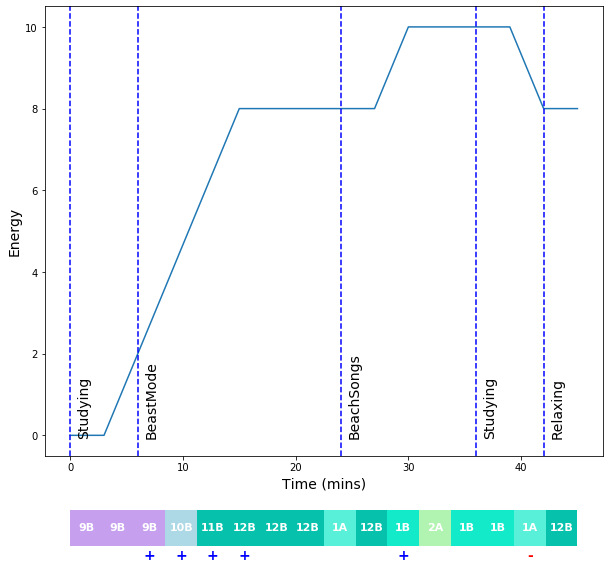

In [33]:
# Create figure and axes
fig_size = (10,10)
fnt_size = 14
if(total_time > 100):
    t = int(total_time/9)
    fig_size = (t,t)
    fnt_size = int(total_time/6)
fig = plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(2,1, height_ratios=[3, 0.3]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x_axis,y_axis)
ax1 = plt.subplot(gs[1])
time_dur = 0
for activity in schedule:
    dur = to_minutes(activity["duration"])
    ax0.axvline(x=time_dur, color='b', linestyle='--')
    activity_name = activity_names[activity["activity"]] 
    ax0.text(time_dur + total_time/80,0,activity_name,rotation=90, fontsize = fnt_size)
    time_dur += dur
    
xp, yp = 4,20
width = 7
height = 8

color_dic = {1:"xkcd:aqua",
             2:"lightgreen",
             3:"xkcd:yellowgreen",
             4: "xkcd:wheat",
             5: "coral",
             6: "xkcd:salmon",
             7: "xkcd:pink",
             8: "xkcd:orchid",
             9: "xkcd:lavender",
             10: "lightblue",
             11: "xkcd:turquoise",
             12:"xkcd:turquoise"
    
            }


for i,song in enumerate(playlist):
    cam_key = song["key_no_norm"] + 1
    cam_mode = camelot_mode[song["mode"]]
    if cam_mode == "A":
        a = 0.7
    else:
        a = 1
    
    rect = mpatches.Rectangle((xp,yp), width, height, angle=0.0, color=color_dic[cam_key], alpha=a, linewidth=0)
    if i > 0:
        ec= energy_list[i-1]
        if ec == 1:
            ax1.text(xp+ (width/2),(yp - height/4), "+", ha = "center", va='center',color = "blue",fontsize=fnt_size, fontweight='bold')
        elif ec == 0:
            ax1.text(xp+ (width/2),(yp - height/4), "-", ha = "center", va='center',color = "red",fontsize=fnt_size, fontweight='bold')
        

    ax1.text(xp+ (width/2),yp + (height/2), str(cam_key) + cam_mode, ha='center', va='center', fontsize=11, fontweight='bold', color="white")
    xp = xp + width
    ax1.add_patch(rect)
#     print(color_dic[cam_key])
# ax.add_patch(rects)
ax0.set_xlabel('Time (mins)',fontsize = 14)
ax0.set_ylabel('Energy',fontsize = 14)
plt.axis('equal')
plt.axis('off')
# plt.tight_layout()

plt.show()

In [30]:
## Save Images
IMAGE_DIR = "Images"
file_name = "Shedule3.png"
file_name = os.path.join(IMAGE_DIR, file_name)
fig.savefig(file_name)
fig_size

(10, 10)